# NLP Methods on Music Reviews
This project explores text preprocessing, lexicon normalization, and modeling of music reviews, retrieved from the Kaggle dataset [song reviews](https://www.kaggle.com/nolanbconaway/pitchfork-data)

In [155]:

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics
from sklearn.model_selection import train_test_split
from matplotlib import cm
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.naive_bayes import MultinomialNB
import sqlite3
import string, re
import nltk
from nltk.collocations import * 
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Khyatee/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/Khyatee/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/Khyatee/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

# Import Data
The data is stored as a series of tables within a sqlite database. The following cells extract each table and convert them to Pandas dataframes.

### Connect to the Database

In [2]:
connection = sqlite3.connect('datasets/reviews.sqlite')
cursor = connection.cursor()

### Reviews Table

In [184]:
query = "select * from reviews;"
cursor.execute(query)
df_reviews = pd.DataFrame(cursor.fetchall(), columns=["id",'track', 'artist', 'url','score',
    'best_new_music', 'author', 'author_type','date','weekday', 'day', 'month', 'year'])
df_reviews.head()

,id,track,artist,url,score,best_new_music,author,author_type,date,weekday,day,month,year
0,22703,mezzanine,massive attack,http://pitchfork.com/reviews/albums/22703-mezz...,9.3,0,nate patrin,contributor,2017-01-08,6,8,1,2017
1,22721,prelapsarian,krallice,http://pitchfork.com/reviews/albums/22721-prel...,7.9,0,zoe camp,contributor,2017-01-07,5,7,1,2017
2,22659,all of them naturals,uranium club,http://pitchfork.com/reviews/albums/22659-all-...,7.3,0,david glickman,contributor,2017-01-07,5,7,1,2017
3,22661,first songs,"kleenex, liliput",http://pitchfork.com/reviews/albums/22661-firs...,9.0,1,jenn pelly,associate reviews editor,2017-01-06,4,6,1,2017
4,22725,new start,taso,http://pitchfork.com/reviews/albums/22725-new-...,8.1,0,kevin lozano,tracks coordinator,2017-01-06,4,6,1,2017


### Content Table

In [4]:
query = "select * from content;"
cursor.execute(query)
df_content = pd.DataFrame(cursor.fetchall(), columns=["id",'review'])
df_content.head()

,id,review
0,22703,"“Trip-hop” eventually became a ’90s punchline,..."
1,22721,"Eight years, five albums, and two EPs in, the ..."
2,22659,Minneapolis’ Uranium Club seem to revel in bei...
3,22661,Kleenex began with a crash. It transpired one ...
4,22725,It is impossible to consider a given release b...


### Genres Table

In [5]:
query = "select * from genres;"
cursor.execute(query)
df_genres = pd.DataFrame(cursor.fetchall(), columns=["id",'genre'])
df_genres.head()

,id,genre
0,22703,electronic
1,22721,metal
2,22659,rock
3,22661,rock
4,22725,electronic


## Merge Dataframes

In [185]:
df = df_content.merge(df_reviews, on='id')
df.sample(5)

,id,review,track,artist,url,score,best_new_music,author,author_type,date,weekday,day,month,year
14100,2765,Drone music directs a listener's attention to ...,talk amongst the trees,eluvium,http://pitchfork.com/reviews/albums/2765-talk-...,7.9,0,mark richardson,executive editor,2005-02-25,4,25,2,2005
7506,14551,Band name changes can be a widespread irritant...,church with no magic,pvt,http://pitchfork.com/reviews/albums/14551-chur...,7.1,0,larry fitzmaurice,contributor,2010-08-17,1,17,8,2010
7567,14502,Cloud Seed mostly comprises tracks the duo of ...,cloud seed,vex'd,http://pitchfork.com/reviews/albums/14502-clou...,7.8,0,tal rosenberg,contributor,2010-07-30,4,30,7,2010
3203,19227,Were Teeny Lieberson the protagonist of a pulp...,the way & the color,teen,http://pitchfork.com/reviews/albums/19227-teen...,6.6,0,jeremy gordon,contributor,2014-04-21,0,21,4,2014
9645,12328,If there's any lingering suspicion that alter ...,skeletal lamping,of montreal,http://pitchfork.com/reviews/albums/12328-skel...,5.9,0,adam moerder,None,2008-10-21,1,21,10,2008


## Create target variable

In [198]:
df =df[(df.score>8) | (df.score<6)]

In [201]:
df['target']=np.where(df.score>8, 1,0)

In [213]:
df

,review,target
0,"“Trip-hop” eventually became a ’90s punchline,...",1
3,Kleenex began with a crash. It transpired one ...,1
4,It is impossible to consider a given release b...,1
9,There were innumerable cameos at the Bad Boy F...,0
11,"On 2006’s “That’s Life,” Killer Mike boasted “...",1
...,...,...
18389,Remember back in elementary school when multim...,1
18390,The ripples from Jawbox's dive into the underg...,1
18393,"I'm psyched. Y'know why? Okay, okay, if you'...",1
18396,The marketing guys of yer average modern megac...,1


## Downsample
The dataset has imbalanced classes, so we use downsampling because we are dealing with text data, which is difficult to upsample

In [7]:
df.best_new_music.value_counts()

0    17458
1      943
Name: best_new_music, dtype: int64

### Take a random sample of 1000 observations from negative class

In [8]:
neg_class_indices = df[df['best_new_music'] == 0].index
random_indices = np.random.choice(neg_class_indices, 1000, replace=False)
neg_class_sample = df.loc[random_indices]


In [9]:
df = pd.concat([df[df['best_new_music'] == 1], neg_class_sample])
df = df.loc[:,['review', 'best_new_music']]
df.best_new_music.value_counts()

0    1000
1     943
Name: best_new_music, dtype: int64

In [145]:
df.iloc[942]

review            Language is for suckers, but due to the limita...
best_new_music                                                    1
Name: 16418, dtype: object

# Data Cleaning
The following cells perform text preprocessing steps, such as stop word / punctuation removal, and lexicon normalization

In [208]:
df = df.loc[:,['review', 'target']]
reviews = df['review']
target = df['target']

In [209]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

### Stopword Removal

In [269]:
## setting stopwords and punctuations
stopword_list = stopwords.words('english')
stopword_list += list(string.punctuation)
stopword_list += ["''", '""', '...', '``', '’', '“', '’', '”', '‘', '‘', '©',
            "n't", "'s", "'re", '-', '–', '—','\r\n','\r','\n', '--']
stopword_list.remove('&')
stopword_set = set(stopword_list)


In [270]:
# define a function that removes stopwords
def remove_stopwords(article):
    tokens = nltk.word_tokenize(article)
    stopwords_removed = [token.lower() for token in tokens if token.lower() not in stopword_set]
    return stopwords_removed 

# Bag of Words

In [271]:
best_reviews = df['review'][df['target']==1]
not_best_reviews = df['review'][df['target']==0]

### Remove Stopwords

In [272]:
reviews_stopped = list(map(remove_stopwords, reviews))
best_reviews_stopped = list(map(remove_stopwords, best_reviews))
not_best_reviews_stopped = list(map(remove_stopwords, not_best_reviews))

In [273]:
total_vocab_best = set()
for word in best_reviews_stopped:
    total_vocab_best.update(word)
len(total_vocab_best)

99309

In [274]:
total_vocab_NOT_best = set()
for word in not_best_reviews_stopped:
    total_vocab_NOT_best.update(word)
len(total_vocab_NOT_best)

86284

### Flatten list of lists

In [275]:
flat_best_reviews = [item for sublist in best_reviews_stopped for item in sublist]
flat_not_best_reviews = [item for sublist in not_best_reviews_stopped for item in sublist]

In [276]:
best_freq = FreqDist(flat_best_reviews)
not_best_freq = FreqDist(flat_not_best_reviews)

### Most Common Words

In [277]:
best_freq.most_common(20)

[('like', 11997),
 ('album', 8764),
 ('music', 8556),
 ('one', 7670),
 ('band', 6777),
 ('songs', 5446),
 ('sound', 4776),
 ('song', 4756),
 ('even', 4715),
 ('record', 4355),
 ('time', 4304),
 ('new', 4293),
 ('first', 4221),
 ('two', 3374),
 ('way', 3294),
 ('guitar', 3255),
 ('sounds', 3249),
 ('much', 3246),
 ('would', 3236),
 ('rock', 3233)]

In [278]:
not_best_freq.most_common(20)

[('like', 10488),
 ('album', 7063),
 ('one', 5400),
 ('band', 5146),
 ('music', 4595),
 ('songs', 4325),
 ('even', 4284),
 ('song', 3945),
 ('sound', 3450),
 ('much', 3176),
 ('record', 3091),
 ('new', 2890),
 ('time', 2821),
 ('could', 2656),
 ('rock', 2643),
 ('sounds', 2623),
 ('first', 2619),
 ('would', 2584),
 ('track', 2531),
 ('way', 2375)]

### Normalized Word Frequencies

In [223]:
best_reviews_total_word_count = sum(best_freq.values())
best_top_25 = best_freq.most_common(25)
print("Word \t\t Normalized Frequency")
print()
for word in best_top_25:
    normalized_frequency = word[1]/best_reviews_total_word_count
    print("{} \t\t {:.4}".format(word[0], normalized_frequency))

Word 		 Normalized Frequency

like 		 0.008328
album 		 0.006084
music 		 0.00594
one 		 0.005324
band 		 0.004705
songs 		 0.003781
sound 		 0.003315
song 		 0.003302
even 		 0.003273
record 		 0.003023
time 		 0.002988
new 		 0.00298
first 		 0.00293
two 		 0.002342
way 		 0.002287
guitar 		 0.00226
sounds 		 0.002255
much 		 0.002253
would 		 0.002246
rock 		 0.002244
also 		 0.002184
track 		 0.002182
could 		 0.002174
tracks 		 0.002085
still 		 0.002067


In [224]:
not_best_reviews_total_word_count = sum(not_best_freq.values())
not_best_top_25 = not_best_freq.most_common(25)
print("Word \t\t Normalized Frequency")
print()
for word in not_best_top_25:
    normalized_frequency = word[1]/not_best_reviews_total_word_count
    print("{} \t\t {:.4}".format(word[0], normalized_frequency))

Word 		 Normalized Frequency

like 		 0.009788
album 		 0.006592
one 		 0.00504
band 		 0.004803
music 		 0.004288
songs 		 0.004037
even 		 0.003998
song 		 0.003682
sound 		 0.00322
much 		 0.002964
record 		 0.002885
new 		 0.002697
time 		 0.002633
could 		 0.002479
rock 		 0.002467
sounds 		 0.002448
first 		 0.002444
would 		 0.002412
track 		 0.002362
way 		 0.002217
get 		 0.002153
still 		 0.002132
tracks 		 0.002121
two 		 0.002097
little 		 0.001994


# Word Clouds

In [225]:
top_words_best = [x[0] for x in best_freq.most_common(25)]
top_words_best_count = [x[1] for x in best_freq.most_common(25)]

top_words_not_best = [x[0] for x in not_best_freq.most_common(25)]
top_words_not_best_count = [x[1] for x in not_best_freq.most_common(25)]

In [226]:
from wordcloud import WordCloud
best_dictionary = dict(zip(top_words_best, top_words_best_count))
not_best_dictionary = dict(zip(top_words_not_best, top_words_not_best_count))

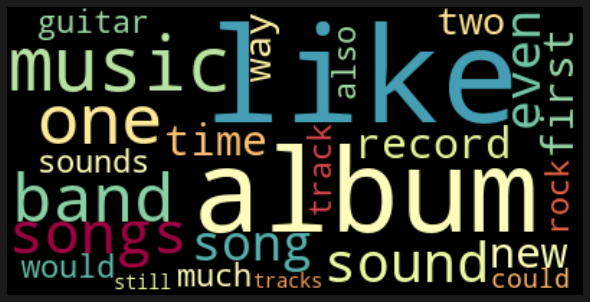

In [227]:
wordcloud = WordCloud(colormap='Spectral').generate_from_frequencies(best_dictionary)

plt.figure(figsize=(8,8), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

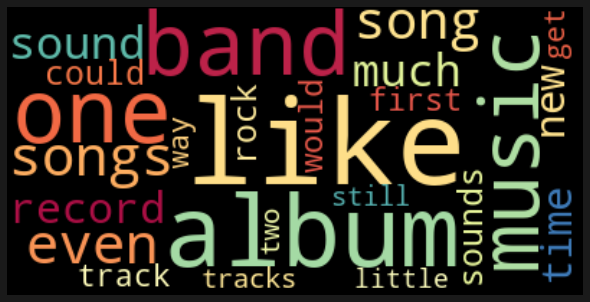

In [228]:
wordcloud = WordCloud(colormap='Spectral').generate_from_frequencies(not_best_dictionary)

plt.figure(figsize=(8,8), facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

# Bigrams

In [279]:
bigram_measures = nltk.collocations.BigramAssocMeasures() 

best_bigrams = BigramCollocationFinder.from_words(flat_best_reviews)
not_best_bigrams = BigramCollocationFinder.from_words(flat_not_best_reviews)

In [280]:
# bigram scores
scored_best = best_bigrams.score_ngrams(bigram_measures.raw_freq)  
scored_not_best = not_best_bigrams.score_ngrams(bigram_measures.raw_freq)


In [283]:
scored_best[:20]

[(('sounds', 'like'), 0.0006344948865953074),
 (('sound', 'like'), 0.00040011316892403536),
 (('title', 'track'), 0.00036336100609392466),
 (('new', 'york'), 0.00035642663574862076),
 (('feels', 'like'), 0.0003418644580234826),
 (('&', 'b'), 0.0003099663544350846),
 (('r', '&'), 0.000307192606296963),
 (('last', 'year'), 0.00027876168788121703),
 (('liner', 'notes'), 0.00025518482870718376),
 (('first', 'time'), 0.00022883422139502888),
 (('feel', 'like'), 0.00021288516960082991),
 (('indie', 'rock'), 0.00020941798442817796),
 (('dance', 'music'), 0.00020456392518646523),
 (('songs', 'like'), 0.00020387048815193482),
 (('electronic', 'music'), 0.00018168050304696233),
 (('acoustic', 'guitar'), 0.0001754395697361888),
 (('years', 'later'), 0.00017127894752900648),
 (('years', 'ago'), 0.00016503801421823296),
 (('gon', 'na'), 0.00015671676980386827),
 (('box', 'set'), 0.00014978239945856437)]

In [284]:
scored_not_best[:20]

[(('sounds', 'like'), 0.000897833452360752),
 (('sound', 'like'), 0.0005957586459590036),
 (('title', 'track'), 0.000415819023627098),
 (('feels', 'like'), 0.00035614992606625883),
 (('last', 'year'), 0.0002946161692066434),
 (('indie', 'rock'), 0.0002927515099078672),
 (('new', 'york'), 0.00026571395007561193),
 (('feel', 'like'), 0.00025639065358173084),
 (('songs', 'like'), 0.00024147337919152103),
 (('gon', 'na'), 0.00022748843445069935),
 (('&', 'b'), 0.0002256237751519231),
 (('tracks', 'like'), 0.00021350348970987766),
 (('r', '&'), 0.00021070650076171333),
 (('years', 'ago'), 0.00020697718216416088),
 (('pretty', 'much'), 0.00020511252286538464),
 (("'ve", 'got'), 0.00019019524847517486),
 (('seems', 'like'), 0.00017621030373435317),
 (('debut', 'album'), 0.00017341331478618884),
 (('acoustic', 'guitar'), 0.00016688700724047206),
 (('wan', 'na'), 0.0001631576886429196)]

# Lexicon Normalization


## Lemmatization
Create a list with all lemmatized outputs

In [247]:
from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer() 

lemmatized_output = []
for listt in reviews_stopped:
    lemmed = ' '.join([lemmatizer.lemmatize(word) for word in listt])
    lemmatized_output.append(lemmed)

In [248]:
X_lem = lemmatized_output
y_lem = target

## Stemming

In [251]:
# Stemming
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

stemmed_output = []
for listt in reviews_stopped:
    stemmed = ' '.join([stemmer.stem(word) for word in listt])
    stemmed_output.append(stemmed)

In [252]:
X_stem = stemmed_output
y_stem = target

### Train/Test Split

In [253]:
# train test split the lemmatized words
X_train_lem, X_test_lem, y_train_lem, y_test_lem = train_test_split(X_lem, y_lem, test_size=0.20, random_state=1)


In [254]:
# train test split the stemmed words
X_train_stem, X_test_stem, y_train_stem, y_test_stem = train_test_split(X_stem, y_stem, test_size=0.20, random_state=1)


# TF-IDF

In [255]:
tfidf = TfidfVectorizer()
tfidf_data_train_lem = tfidf.fit_transform(X_train_lem)
tfidf_data_test_lem = tfidf.transform(X_test_lem)


In [256]:
# get a quick look of the non zero elements

non_zero_cols = tfidf_data_train_lem.nnz / float(tfidf_data_train_lem.shape[0])
print("Average Number of Non-Zero Elements in Vectorized Articles: {}".format(non_zero_cols))

percent_sparse = 1 - (non_zero_cols / float(tfidf_data_train_lem.shape[1]))
print('Percentage of columns containing ZERO: {}'.format(percent_sparse))

Average Number of Non-Zero Elements in Vectorized Articles: 337.60998537706286
Percentage of columns containing ZERO: 0.9949926585085644


# T-SNE

In [257]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2).fit_transform(tfidf_data_train_stem)

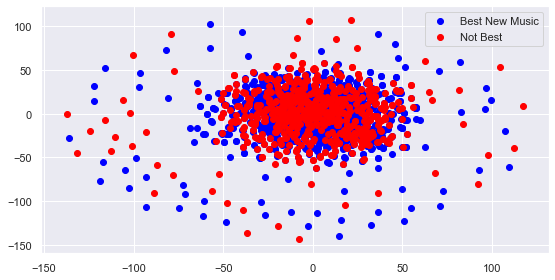

In [258]:
best_2d = X_embedded[:943]
best_x = [i[0] for i in best_2d]
best_y = [i[1] for i in best_2d]

not_best_2d = X_embedded[943:]
not_best_x = [i[0] for i in not_best_2d]
not_best_y = [i[1] for i in not_best_2d]

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(222)
ax.scatter(best_x, best_y, c='blue', label='Best New Music')
ax.scatter(not_best_x, not_best_y, c='red', label='Not Best')
ax.legend()
plt.show()

# Classification
## TFIDF and Lemming

In [259]:
forest_lem = RandomForestClassifier(n_estimators=100, random_state=0)
forest_lem.fit(tfidf_data_train_lem, y_train_lem)
forest_test_preds_lem = forest_lem.predict(tfidf_data_test_lem)

In [260]:
forest_acc_score_lem = accuracy_score(y_test_lem, forest_test_preds_lem)
forest_f1_score_lem = f1_score(y_test_lem, forest_test_preds_lem)
print('Random Forest with Lemmatization Features')
print("Testing Accuracy: {:.4}".format(forest_acc_score_lem))
print()
print("F1 Score: {:.4}".format(forest_f1_score_lem))

Random Forest with Lemmatization Features
Testing Accuracy: 0.787

F1 Score: 0.7713


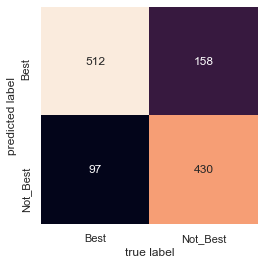

In [261]:
from sklearn.metrics import confusion_matrix
import seaborn as sns; sns.set()


mat = confusion_matrix(y_test_lem, forest_test_preds_lem)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=['Best', 'Not_Best'], yticklabels=['Best', 'Not_Best'])
plt.xlabel('true label')
plt.ylabel('predicted label');

## TFIDF and Stemming


In [262]:
tfidf = TfidfVectorizer()
tfidf_data_train_stem = tfidf.fit_transform(X_train_stem)
tfidf_data_test_stem = tfidf.transform(X_test_stem)

### Random Forest

In [263]:
forest_stem = RandomForestClassifier(n_estimators=100, random_state=0)
forest_stem.fit(tfidf_data_train_stem, y_train_stem)
forest_test_preds_stem = forest_stem.predict(tfidf_data_test_stem)

In [264]:
forest_acc_score_stem = accuracy_score(y_test_stem, forest_test_preds_stem)
forest_f1_score_stem = f1_score(y_test_stem, forest_test_preds_stem)
print('Random Forest with Lemmatization Features')
print("Testing Accuracy: {:.4}".format(forest_acc_score_stem))
print()
print("F1 Score: {:.4}".format(forest_f1_score_stem))

Random Forest with Lemmatization Features
Testing Accuracy: 0.7945

F1 Score: 0.7827


## Count Vectorizer

In [265]:
from sklearn.feature_extraction.text import CountVectorizer

vec = CountVectorizer(stop_words=stopword_list)
vec_data_train_lem = vec.fit_transform(X_train_lem)
vec_data_test_lem = vec.transform(X_test_lem)

In [266]:
forest_lem = RandomForestClassifier(n_estimators=100, random_state=0)
forest_lem.fit(vec_data_train_lem, y_train_lem)
forest_test_preds_lem = forest_lem.predict(vec_data_test_lem)

In [267]:
forest_acc_score_lem = accuracy_score(y_test_lem, forest_test_preds_lem)
forest_f1_score_lem = f1_score(y_test_lem, forest_test_preds_lem)
print('Random Forest with Lemmatization Features')
print("Testing Accuracy: {:.4}".format(forest_acc_score_lem))
print()
print("F1 Score: {:.4}".format(forest_f1_score_lem))

Random Forest with Lemmatization Features
Testing Accuracy: 0.8237

F1 Score: 0.8189
